In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from scipy.stats import pearsonr, ttest_ind
from sklearn.preprocessing import MinMaxScaler


In [2]:
mdata = pd.read_csv("mdata.csv")

In [3]:
mdata['DATE'] = pd.to_datetime(mdata['DATE'])
mdata['MONTH']=mdata['DATE'].dt.month

In [4]:
monthly_metrics = mdata.groupby(['STORE_NBR', 'MONTH']).agg(
    total_sales=('TOT_SALES', 'sum'),
    total_customers=('LYLTY_CARD_NBR', lambda x: x.nunique()),
    transactions_per_customer=('LYLTY_CARD_NBR', lambda x: x.count()/x.nunique())
).reset_index()



In [5]:
MONTH_ORDER = {7: 1, 8: 2, 9: 3, 10: 4, 11: 5, 12: 6, 1: 7, 2: 8, 3: 9, 4: 10, 5: 11, 6: 12}
monthly_metrics['MONTH_ORDER'] = monthly_metrics['MONTH'].map(MONTH_ORDER)
monthly_metrics = monthly_metrics.sort_values(['STORE_NBR', 'MONTH_ORDER'])
# monthly_metrics = monthly_metrics.drop(columns=['MONTH_ORDER'])
monthly_metrics = monthly_metrics.reset_index(drop=True)

## best_match1

In [6]:
trial_metrics = monthly_metrics[monthly_metrics['STORE_NBR'] == 77].sort_values('MONTH')
# First, collect all differences to normalize across all stores
all_diffs = []

for store in monthly_metrics['STORE_NBR'].unique():
    if store == 77:
        continue

    control_metrics = monthly_metrics[monthly_metrics['STORE_NBR'] == store].sort_values('MONTH')
    if len(control_metrics) < 12:  # filter to reach stores that are operational for the entire observation period.
        continue

    merged = pd.merge(trial_metrics, control_metrics, on='MONTH', suffixes=('_trial', '_control'))
    merged = merged[merged['MONTH'].isin([7,8,9,10,11,12,1,2])]
    
    # Calculate differences for this store
    diff = abs(merged['total_sales_trial'] - merged['total_sales_control'])
    all_diffs.extend(diff.tolist())



# Now calculate scores with global normalization

control_scores = []
for store in monthly_metrics['STORE_NBR'].unique():
    if store == 77:
        continue

    control_metrics = monthly_metrics[monthly_metrics['STORE_NBR'] == store].sort_values('MONTH')
    if len(control_metrics) < 12:
        continue

    merged = pd.merge(trial_metrics, control_metrics, on='MONTH', suffixes=('_trial', '_control'))
    merged = merged[merged['MONTH'].isin([7,8,9,10,11,12,1,2])]
    # Global normalization
    global_min = min(all_diffs)
    global_max = max(all_diffs)

    corr, _ = pearsonr(merged['total_sales_trial'], merged['total_sales_control'])
    corr_score = max(0, corr)   # just positive indicator
    diff = abs(merged['total_sales_trial'] - merged['total_sales_control'])
    mag = 1 - (diff - global_min) / (global_max-global_min)
    mag_score = mag.mean()
    final_score = (1.0*corr_score + 0.0*mag_score)  # positive indicator, the higher the more similar
    control_scores.append((store, final_score))

best_match1 = sorted(control_scores, key=lambda x: x[1], reverse=True)
best_match1


[(233, 0.9516145370414857),
 (162, 0.8545977400683735),
 (50, 0.7897528147725177),
 (157, 0.7841135386310024),
 (30, 0.7495885312916646),
 (71, 0.7343197313232523),
 (17, 0.6970941117112176),
 (113, 0.694289016734511),
 (35, 0.6926628807806572),
 (105, 0.6847720856821127),
 (60, 0.6745158218437699),
 (234, 0.670972823874774),
 (167, 0.670673397638854),
 (53, 0.6533074663551557),
 (250, 0.6420931521889217),
 (115, 0.6239975590989435),
 (257, 0.6199786201190164),
 (27, 0.6176334124663851),
 (237, 0.6023175891591876),
 (254, 0.6007971215409905),
 (192, 0.5981740656059944),
 (119, 0.573245834863851),
 (121, 0.559270924691925),
 (84, 0.5423050737832139),
 (202, 0.5319201583345193),
 (69, 0.5308943726293087),
 (195, 0.5161281881405223),
 (37, 0.5138950387811363),
 (10, 0.5114138754889074),
 (221, 0.4975020462940145),
 (236, 0.4970499125853733),
 (96, 0.49537869941699825),
 (148, 0.4792070412075226),
 (48, 0.47485241722480875),
 (161, 0.47349553264209504),
 (199, 0.4567368998542089),
 (20, 0.

## best_match2

In [7]:
trial_metrics = monthly_metrics[monthly_metrics['STORE_NBR'] == 77].sort_values('MONTH')
# First, collect all differences to normalize across all stores
all_diffs = []

for store in monthly_metrics['STORE_NBR'].unique():
    if store == 77:
        continue

    control_metrics = monthly_metrics[monthly_metrics['STORE_NBR'] == store].sort_values('MONTH')
    if len(control_metrics) < 12:  # filter to reach stores that are operational for the entire observation period.
        continue

    merged = pd.merge(trial_metrics, control_metrics, on='MONTH', suffixes=('_trial', '_control'))
    merged = merged[merged['MONTH'].isin([7,8,9,10,11,12,1,2])]
    
    # Calculate differences for this store
    diff = abs(merged['total_customers_trial'] - merged['total_customers_control'])
    all_diffs.extend(diff.tolist())



# Now calculate scores with global normalization

control_scores = []
for store in monthly_metrics['STORE_NBR'].unique():
    if store == 77:
        continue

    control_metrics = monthly_metrics[monthly_metrics['STORE_NBR'] == store].sort_values('MONTH')
    if len(control_metrics) < 12:
        continue

    merged = pd.merge(trial_metrics, control_metrics, on='MONTH', suffixes=('_trial', '_control'))
    merged = merged[merged['MONTH'].isin([7,8,9,10,11,12,1,2])]
    # Global normalization
    global_min = min(all_diffs)
    global_max = max(all_diffs)

    corr, _ = pearsonr(merged['total_customers_trial'], merged['total_customers_control'])
    corr_score = max(0, corr)   # just positive indicator
    diff = abs(merged['total_customers_trial'] - merged['total_customers_control'])
    mag = 1 - (diff - global_min) / (global_max-global_min)
    mag_score = mag.mean()
    final_score = (1.0*corr_score + 0.0*mag_score)  # positive indicator, the higher the more similar
    control_scores.append((store, final_score))

best_match2 = sorted(control_scores, key=lambda x: x[1], reverse=True)
best_match2


[(233, 0.9498158264965949),
 (35, 0.8906242127017729),
 (119, 0.8675929858944993),
 (88, 0.8575675519626931),
 (237, 0.8475753218276002),
 (254, 0.8227373094391401),
 (178, 0.7818331318339174),
 (162, 0.7817018981402759),
 (14, 0.7653397582284173),
 (157, 0.7571570673631272),
 (57, 0.7242471620158402),
 (27, 0.7052725328266342),
 (250, 0.703497594964563),
 (113, 0.6725782672300435),
 (167, 0.6496299808172611),
 (105, 0.6475912876641325),
 (53, 0.6450569515320959),
 (248, 0.61157671616446),
 (50, 0.6087282308316647),
 (71, 0.5959509288382956),
 (3, 0.5783904597523396),
 (72, 0.5774030272475834),
 (17, 0.5695117368415802),
 (195, 0.5531957764862028),
 (229, 0.5435526277712499),
 (37, 0.5230959240867978),
 (69, 0.5092430276321196),
 (84, 0.5089031170026656),
 (41, 0.49938113014246943),
 (265, 0.49808616729129646),
 (46, 0.47687180786033073),
 (145, 0.45706756450126007),
 (181, 0.4537853549112895),
 (230, 0.44674628754004153),
 (64, 0.4455297032885488),
 (234, 0.4403756754229417),
 (60, 0.

## best_match3

In [8]:
# Convert best_match1 and best_match2 to dictionaries for easier lookup
best_match1_dict = dict(best_match1)
best_match2_dict = dict(best_match2)

# Get all unique store numbers from both matches
all_stores = set(best_match1_dict.keys()).union(set(best_match2_dict.keys()))

# Calculate the mean score for each store
best_match3 = []
for store in all_stores:
    # Get scores from both matches, defaulting to 0 if not present
    score1 = best_match1_dict.get(store, 0)
    score2 = best_match2_dict.get(store, 0)
    
    # Calculate mean score
    mean_score = (0.7 * score1 + 0.3 * score2)
    
    # Add to best_match3
    best_match3.append((store, mean_score))

# Sort by score in descending order
best_match3 = sorted(best_match3, key=lambda x: x[1], reverse=True)
best_match3


[(233, 0.9510749238780183),
 (162, 0.8327289874899442),
 (157, 0.7760265972506398),
 (35, 0.7520512803569919),
 (50, 0.7354454395902618),
 (71, 0.6928090905777653),
 (113, 0.6877757918831707),
 (237, 0.6758949089597114),
 (105, 0.6736178462767186),
 (254, 0.6673791779104354),
 (167, 0.6643603725923761),
 (119, 0.6615499801730453),
 (250, 0.660514485021614),
 (17, 0.6588193992503264),
 (53, 0.6508323119082378),
 (27, 0.6439251485744598),
 (30, 0.640463976274817),
 (234, 0.6017936793392242),
 (60, 0.599967059251862),
 (115, 0.5642327908374468),
 (257, 0.5494613531737867),
 (84, 0.5322844867490494),
 (195, 0.5272484646442264),
 (69, 0.5243989691301519),
 (37, 0.5166553043728347),
 (3, 0.48451427329505037),
 (121, 0.47823372931603836),
 (192, 0.47726248260130916),
 (202, 0.4720261700860707),
 (248, 0.46498423494318564),
 (236, 0.4595107051779673),
 (265, 0.45742238023716986),
 (203, 0.4395121797218974),
 (96, 0.43489057152944594),
 (10, 0.4247902645015151),
 (161, 0.4241417957646352),
 (22

### as we already knew, we found that store 233 is most similar to store 77 both on factors of total_sales and total_customers. and we already saw that based on this store, the campaign works well. 
### but lets move to the second record on best_match3, which is store 162

But as is shown below, the difference between the mean of the trial store 77 and the new control store 162 is very high both on sales and number of customers. 
therefor using t-test will be useless because it doesnt mean anything. so we go forward to check on the time series plot to see the trends' behaviors.

### T-test (useless)

In [9]:
# total_sales

trial_period = [2, 3, 4]

trial_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == 77) & 
                                (monthly_metrics['MONTH'].isin(trial_period))]

control_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == 162) & 
                                (monthly_metrics['MONTH'].isin(trial_period))]

# Compare total sales
t_stat, p_val = ttest_ind(trial_data['total_sales'], control_data['total_sales'])

print(f"Trial Store {77} vs Control Store {162}")
print(f"  T-Stat: {t_stat:.2f}, P-Value: {p_val:.4f}")
print(f"  Trial Mean: {trial_data['total_sales'].mean():.2f}, Control Mean: {control_data['total_sales'].mean():.2f}")
print("---")

Trial Store 77 vs Control Store 162
  T-Stat: -10.00, P-Value: 0.0006
  Trial Mean: 241.60, Control Mean: 780.07
---


But as is shown below, the difference between the mean of the trial store 77 and the new control store 162 is very high both on sales and number of customers. 
therefor using t-test will be useless because it doesnt mean anything. so we go forward to check on the time series plot to see the trends' behaviors.

### T-test (useless)

In [10]:
# total_customers

trial_period = [2, 3, 4]

trial_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == 77) & 
                                (monthly_metrics['MONTH'].isin(trial_period))]

control_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == 162) & 
                                (monthly_metrics['MONTH'].isin(trial_period))]

# Compare total sales
t_stat, p_val = ttest_ind(trial_data['total_customers'], control_data['total_customers'], equal_var=True)

print(f"Trial Store {77} vs Control Store {53}")
print(f"  T-Stat: {t_stat:.2f}, P-Value: {p_val:.4f}")
print(f"  Trial Mean: {trial_data['total_customers'].mean():.2f}, Control Mean: {control_data['total_customers'].mean():.2f}")
print("---")

Trial Store 77 vs Control Store 53
  T-Stat: -10.18, P-Value: 0.0005
  Trial Mean: 44.33, Control Mean: 89.33
---


### time series plot (total sales)

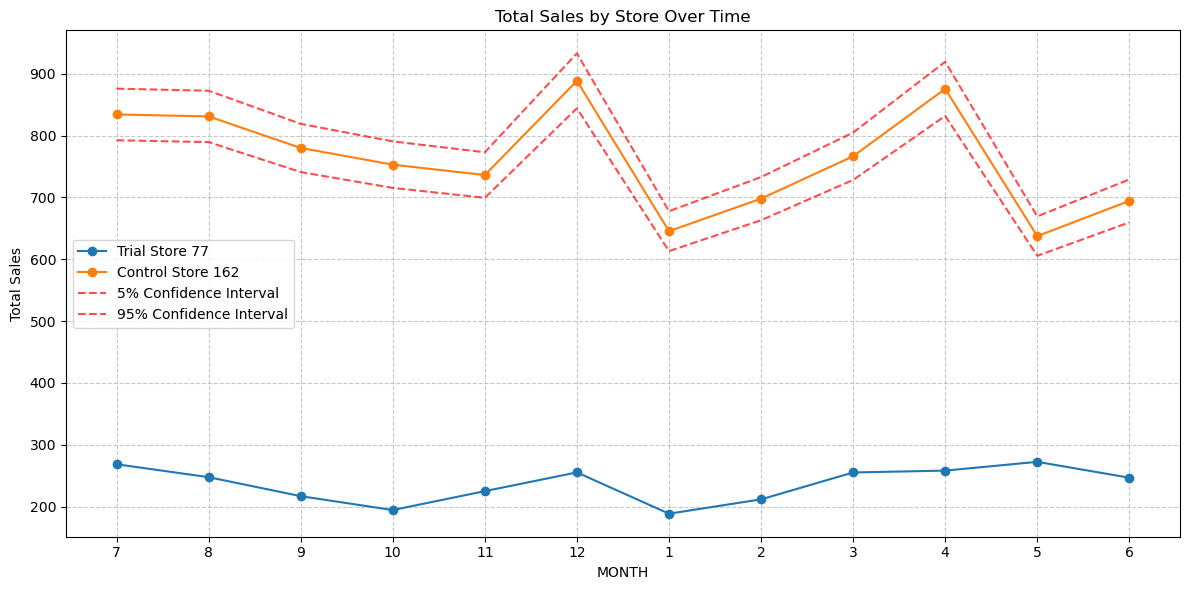

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.figure(figsize=(12, 6))  

trial_store = 77
control_store = 162

trial_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == trial_store)]
plt.plot(trial_data['MONTH_ORDER'], trial_data['total_sales'], label=f'Trial Store {trial_store}', marker='o')


control_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == control_store)]
plt.plot(control_data['MONTH_ORDER'], control_data['total_sales'], label=f'Control Store {control_store}', marker='o')


# Calculating simple Confidence Intervals
confidence_level = 0.05
lower_ci = control_data['total_sales'] * (1 - confidence_level)
upper_ci = control_data['total_sales'] * (1 + confidence_level)


plt.plot(control_data['MONTH_ORDER'], lower_ci, 
         linestyle='--', color='red', alpha=0.7, 
         label='5% Confidence Interval')
plt.plot(control_data['MONTH_ORDER'], upper_ci, 
         linestyle='--', color='red', alpha=0.7, 
         label='95% Confidence Interval')

plt.xticks(trial_data['MONTH_ORDER'], trial_data['MONTH'])
plt.title('Total Sales by Store Over Time')
plt.xlabel('MONTH')
plt.ylabel('Total Sales')
plt.legend()
plt.tight_layout()  
plt.grid(True, linestyle='--', alpha=0.7)  
plt.show()

### time series plot (total customers)

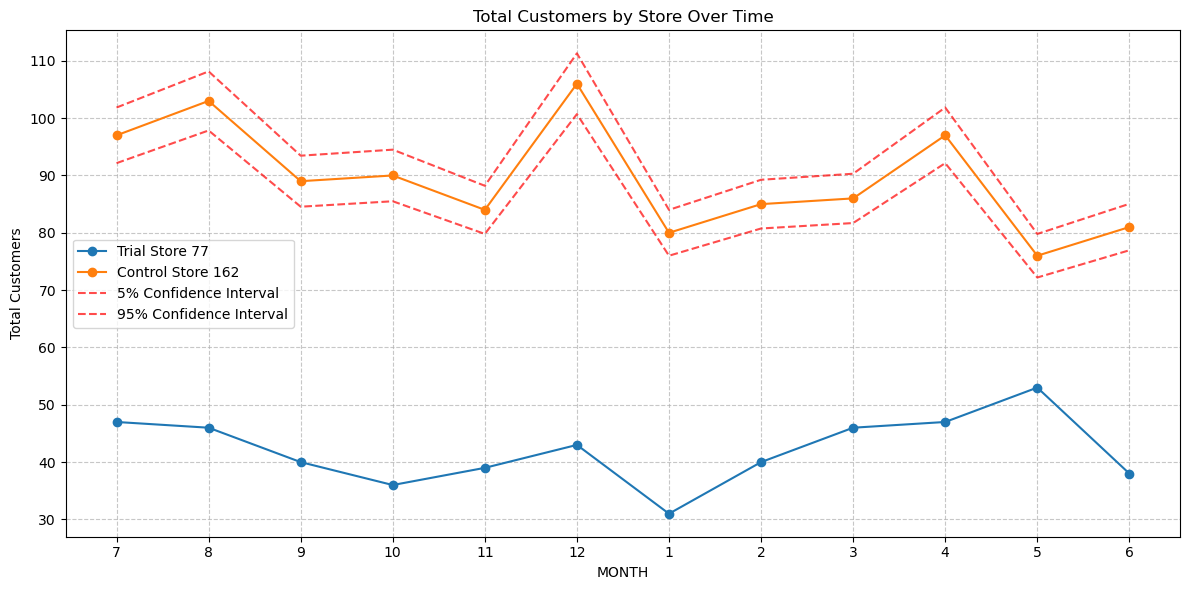

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.figure(figsize=(12, 6))  

trial_store = 77
control_store = 162

trial_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == trial_store)]
plt.plot(trial_data['MONTH_ORDER'], trial_data['total_customers'], label=f'Trial Store {trial_store}', marker='o')


control_data = monthly_metrics[(monthly_metrics['STORE_NBR'] == control_store)]
plt.plot(control_data['MONTH_ORDER'], control_data['total_customers'], label=f'Control Store {control_store}', marker='o')


# Calculating simple Confidence Intervals
confidence_level = 0.05
lower_ci = control_data['total_customers'] * (1 - confidence_level)
upper_ci = control_data['total_customers'] * (1 + confidence_level)


plt.plot(control_data['MONTH_ORDER'], lower_ci, 
         linestyle='--', color='red', alpha=0.7, 
         label='5% Confidence Interval')
plt.plot(control_data['MONTH_ORDER'], upper_ci, 
         linestyle='--', color='red', alpha=0.7, 
         label='95% Confidence Interval')

plt.xticks(trial_data['MONTH_ORDER'], trial_data['MONTH'])
plt.title('Total Customers by Store Over Time')
plt.xlabel('MONTH')
plt.ylabel('Total Customers')
plt.legend()
plt.tight_layout()  
plt.grid(True, linestyle='--', alpha=0.7)  
plt.show()

Observing the new control store 162, for both the factors total sales and number of customers, We found that stores 77 and 162 showed similar performance trends during the campaign period. The parallel movement in the time series plots indicates that external market factors, not our campaign, likely drove the observed improvements. 


# Campaign Effectiveness final Conclusion

Our comprehensive analysis using multiple control stores and metrics reveals mixed evidence for the product replacement campaign's effectiveness. While comparisons with store 233 consistently indicate success across both sales and customer metrics, alternative control stores (50, 35, and 162) suggest the observed improvements may be attributable to broader market trends. This inconsistency across different benchmarks indicates the campaign likely had a positive but modest effect that is sensitive to control store selection. The campaign shows promise but requires further testing with refined methodology before full-scale implementation can be confidently recommended.